# Exercise 2: Deep learning

CSCS-ICS-DADSi Summer School: Accelerating Data Science with HPC
September 4 - 6, 2017
Swiss National Supercomputing Centre

Mainly inspired from:

http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

We will use the PyTorch deep learning framework (http://pytorch.org/) in this exercise.

PyTorch is a Python-based reincarnation of the lua-based Torch framework (http://torch.ch/), with features such as dynamic graphs and general-purpose automatic differentiation.

Please visit the PyTorch website for more information and tutorials.

## Part 1: Tensors

We start by importing `torch`.

In [1]:
import torch
from torch import Tensor

Tensors, or multi-dimensional arrays, are the basic unit in PyTorch. Let's create a 5x3 matrix as a 2-dimensional Tensor. This will default to a `FloatTensor`, a tensor of single-precision (32-bits) floating point numbers. The tensor will be initialized with random numbers.

In [2]:
x = Tensor(5,3)
print(x)


1.00000e-22 *
  3.5701  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000
  0.0000  0.0018  0.0000
  0.0018  0.0000  0.0018
[torch.FloatTensor of size 5x3]



### Slicing

It is common to have higher-dimensional tensors, to hold all aspects of your data together, such as a 3x200x200 tensor holding the R,G,B channels of an image of 200x200 pixels, or a 100x3x200x200 tensor to hold a batch of 100 such images.

We use slicing operations to view specific subtensors of such a tensor. Note that PyTorch uses zero-based indexing and row-major memory ordering.

In [3]:
# 100 images of 3 channels of size 200x200
x = Tensor(100,3,200,200)
print(x.size())

# Second channel of the first image
y = x[0,1]
print(y.size())

torch.Size([100, 3, 200, 200])
torch.Size([200, 200])


### Numpy conversion

You might have noticed that Tensors are very similar to Numpy's ndarrays. In fact you can easily convert between ndarrays and Tensors.

In [4]:
x_np = x.numpy()
print(x_np.shape)

x = torch.from_numpy(x_np)
print(x.size())

(100, 3, 200, 200)
torch.Size([100, 3, 200, 200])


### A note on GPU usage

PyTorch is frequently used with a CUDA backend on a GPU. One would convert between tensors and CUDA tensors by simply calling

`x.cuda()`

`x.cpu()`

which transfer data to and from a GPU memory.

## Part 2: Automatic differentiation

PyTorch implements reverse-mode automatic differentiation (AD). For using AD features, we need the `Variable` class from  `autograd`.

In [5]:
from torch.autograd import Variable

For automatically evaluating derivatives with AD, we need to wrap tensors within `Variable` instances.

In [6]:
x = Tensor(3) # A vector of length three
x = Variable(x) 
print(x)

Variable containing:
 3.5700e-22
 4.5843e-41
 1.0178e-36
[torch.FloatTensor of size 3]



With `Variable`s, obtaining a gradient of a scalar-valued function is straightforward. Let's use the regular Python language features to define a function.

In [7]:
def f(x):
    y = torch.log(x[0]) + torch.sin(x[1])
    return x[2] * torch.exp(y)

Let's evaluate the gradient of `f(x)` at `x = [2,3,4]`.

In [8]:
x = Variable(Tensor([2,3,4]), requires_grad=True)
y = f(x)
print(y)

y.backward()
print(x.grad)

Variable containing:
 9.2125
[torch.FloatTensor of size 1]

Variable containing:
 4.6063
-9.1203
 2.3031
[torch.FloatTensor of size 3]



Note that we get the function evaluated `f(2,3,4)` as `9.2125` and the gradient `f'(2,3,4)` as `[4.6063, -9.1203, 2.3031]`.

Also note the use of `requires_grad = True` for tagging the `Variable` `x` for being differentiated with respect to. This is for efficiency reasons, allowing PyTorch to ignore the bookkeeping for `Variable`s whose derivatives we don't need.

## Part 3: Neural networks

The previous two parts, namely defining and using `Tensor`s and `Variable`s and being able to obtain derivatives, give us everything needed for constructing and training a neural network.

### Defining a neural network

A very important point to note is that **neural networks are just functions, and there is nothing special about them.**

A neural network is a series of linear algebra operations interleaved with non-linear transformations. Let's create a single feed-forward layer with two neurons connected to four inputs (note that this omits the bias term for simplicity).

In [9]:
def run_layer(weights, inputs):
    outputs = torch.mm(weights , inputs)
    outputs = torch.tanh(outputs)
    return outputs

W = Variable(torch.randn(2,4), requires_grad=True) # A 2x4 weight matrix
x = Variable(Tensor([[1],[2],[3],[4]])) # A column vector of length four

y = run_layer(W, x)
print(y)

Variable containing:
-1.0000
-0.9923
[torch.FloatTensor of size 2x1]



### The loss function

Training this neural network layer would simply mean taking the derivative of a loss function at its output with respect to its trainable weights (the matrix `W` above).

In [10]:
def loss(outputs, targets):
    return torch.norm(outputs - targets)

W = Variable(torch.randn(2,4), requires_grad=True) # A 2x4 weight matrix
x = Variable(Tensor([[1],[2],[3],[4]])) # A column vector of length four

loss = loss(run_layer(W, x), Variable(Tensor([1,1,1])))
print(loss)

loss.backward()
W_grad = W.grad
print(W_grad)

Variable containing:
 3.5573
[torch.FloatTensor of size 1]

Variable containing:
-0.2821 -0.5643 -0.8464 -1.1285
-0.0001 -0.0003 -0.0004 -0.0005
[torch.FloatTensor of size 2x4]



### Optimization

We would then iteratively update the weights in a gradient-based update rule.

In [11]:
learning_rate = 0.001
W = W - learning_rate * W_grad
print(W)

Variable containing:
-0.5265  0.0008 -0.7279  0.8278
 0.0988 -0.2791 -0.9714 -0.5097
[torch.FloatTensor of size 2x4]



In [12]:
torch.sigmoid(Tensor([1]))


 0.7311
[torch.FloatTensor of size 1]

By taking the gradient of a neural network with respect to its trainable parameters (weights), we can optimize it with gradient descent.

## Using torch.nn modules

In practice, unless you are implementing new neural network architectures, you would use the existing neural network building blocks provided by the `torch.nn` module, which internally work similar to the basic example we covered above.

We will now define a convolutional neural network for image recognition on the MNIST dataset and train and test it, using the regular PyTorch workflow. The MNIST dataset is a collection of 60,000 images of handwritten digits labeled as belonging to one of the ten digit categories.

First we load the MNIST dataset. We also apply preprocessing for normalizing data.

We divide the data into training and test sets.

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

We define a function that will help us visualize data and labels.

In [14]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    npimg = img.numpy().astype(float)
    plt.imshow(npimg)

Let's inspect a few images and corresponding ground truth labels from the training set.

Ground truth label:  3


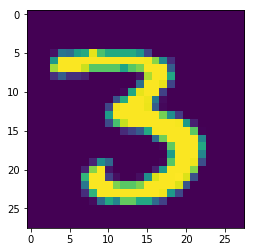

In [15]:
index = 12
imshow(train_loader.dataset.train_data[index])
print('Ground truth label: ', train_loader.dataset.train_labels[index])

Ground truth label:  4


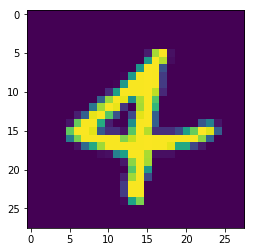

In [16]:
index = 150
imshow(train_loader.dataset.train_data[index])
print('Ground truth label: ', train_loader.dataset.train_labels[index])

Next we define our neural network composed of two convolutional layers followed by max-pooling layers, a dropout layer, and two fully-connected (linear) layers.

Note that we only need to 
- create the layer modules (in the `__init__` constructor) and 
- define the function for the forward run of the network (in the `forward` method)

In [17]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self): # The definition of neural network layers
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x): # The function for forward evaluation
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = Net()

We use the stochastic gradient descent (SGD) optimization routine provided by the `torch.optim` module. We use a learning rate of `0.0001` and a momentum of `0.9`.

In [18]:
from torch import optim

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [19]:
import torch.nn.functional as F

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

We train the neural network for four epochs. 

As training progresses, you will see that the classification accuracy in the test set will keep rising. At the end of four epochs, we will have an accuracy of around 85% in the test set.

In [20]:
for epoch in range(1, 5):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304117
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.337224
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.316170
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.293122
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.315565
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.285456
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.291956
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.239765
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.266539
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.248861

Test set: Average loss: 2.2314, Accuracy: 4130/10000 (41%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.253264
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.227257
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.259247
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.231233
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.170665
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.232805
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.160343
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.157897
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.168804
T

Let's test some images from the test set. You can evaluate the same cell many times to visualize results for more test images.

Variable containing:
 0.0040  0.1330  0.0739  0.1268  0.0844  0.0968  0.0378  0.0413  0.2939  0.1081
[torch.FloatTensor of size 1x10]



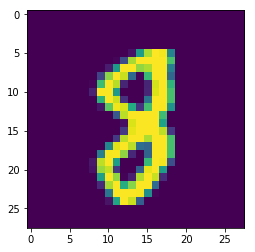

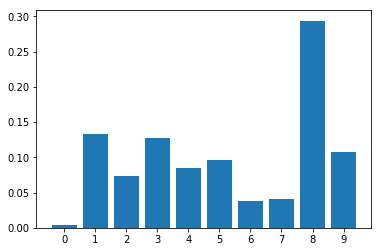

In [84]:
import itertools
index = 3
a = list(itertools.islice(test_loader, index))
test_image = a[0][0][0]
test_label = a[0][1][0]

test_output = model(Variable(test_image.unsqueeze(0)))
values, indices = torch.max(test_output, 0)
imshow(test_image[0])
print(F.softmax(values))
fig, ax = plt.subplots()
ax.bar(range(10),F.softmax(values).data.numpy()[0])
ax.set_xticks(np.arange(10))
plt.show()